### Imports

In [1]:
import zipfile
import os
from tqdm import tqdm

### Load Data

Unzip Data

In [2]:
with zipfile.ZipFile('all_alignments_trimmed.zip', 'r') as zip_ref:
    zip_ref.extractall('Data')

Find FASTA Files

In [3]:
path = './Data/all_alignments_trimmed'
fasta_files = [f for f in os.listdir(path) if f.endswith('.fasta')]
print(fasta_files)

['OG10015_Hmm10-gb.fasta', 'OG10028_Hmm10-gb.fasta', 'OG10087_Hmm10-gb.fasta', 'OG10092_Hmm10-gb.fasta', 'OG10107_Hmm10-gb.fasta', 'OG10131_Hmm10-gb.fasta', 'OG10137_Hmm10-gb.fasta', 'OG10170_Hmm10-gb.fasta', 'OG10206_Hmm10-gb.fasta', 'OG10212_Hmm10-gb.fasta', 'OG10257_Hmm10-gb.fasta', 'OG1026_Hmm10-gb.fasta', 'OG10299_Hmm10-gb.fasta', 'OG10316_Hmm10-gb.fasta', 'OG10325_Hmm10-gb.fasta', 'OG10383_Hmm10-gb.fasta', 'OG10448_Hmm10-gb.fasta', 'OG10449_Hmm10-gb.fasta', 'OG1044_Hmm10-gb.fasta', 'OG10461_Hmm10-gb.fasta', 'OG10511_Hmm10-gb.fasta', 'OG10538_Hmm10-gb.fasta', 'OG10553_Hmm10-gb.fasta', 'OG10561_Hmm10-gb.fasta', 'OG10565_Hmm10-gb.fasta', 'OG10585_Hmm10-gb.fasta', 'OG10619_Hmm10-gb.fasta', 'OG10632_Hmm10-gb.fasta', 'OG10648_Hmm10-gb.fasta', 'OG10672_Hmm10-gb.fasta', 'OG10702_Hmm10-gb.fasta', 'OG10710_Hmm10-gb.fasta', 'OG10769_Hmm10-gb.fasta', 'OG10792_Hmm10-gb.fasta', 'OG10795_Hmm10-gb.fasta', 'OG10803_Hmm10-gb.fasta', 'OG10826_Hmm10-gb.fasta', 'OG10830_Hmm10-gb.fasta', 'OG1085_Hmm10

Function to Get Sequences From FASTA File as Dict

In [4]:
species_counts = {}
gene_counts = {}

# returns a dictionary object with sequence names as keys and sequences as values
def get_sequences(fasta_file):
    with open(os.path.join(path, fasta_file), 'r') as file:
        sequences = {}
        current_seq_name = None
        current_sequence = []
        for line in file:
            line = line.strip()
            if line.startswith('>'):  # Start of a new sequence
                if current_seq_name:  # Save the previous sequence
                    sequences[current_seq_name] = ''.join(current_sequence)
                    species_counts[current_seq_name] = species_counts.get(current_seq_name, 0) + 1
                current_seq_name = line[1:]  # Save the sequence name (exclude '>')
                current_sequence = []  # Reset the sequence buffer
            else:
                current_sequence.append(line)  # Collect sequence data
        if current_seq_name:  # Save the last sequence in the file
            sequences[current_seq_name] = ''.join(current_sequence)
            # species_counts[current_seq_name] = species_counts.get(current_seq_name, 0) + 1
    gene_counts[fasta_file] = len(sequences)
    species_counts["TOTAL GENES"] = species_counts.get("TOTAL GENES", 0) + 1
    return sequences

Dictionary of Dictionaries Containing Sequences for Every Gene

In [5]:
gene_sequences = {}
for fasta_file in fasta_files:
    sequences = get_sequences(fasta_file)
    gene_name = fasta_file.split('_')[0]
    gene_sequences[gene_name] = sequences

Save the Unique Species and their Counts

In [6]:
with open('species_count.txt', 'w') as f:
    for species, count in sorted(species_counts.items(), key=lambda x: x[1], reverse=True):
        f.write(f'{species}\t{count}\n')

### Calculate Distance Matrix

In [7]:
blosum = {}
with open('blosum62.txt', 'r') as f:
    lines = f.readlines()[6:]
    keys = lines[0].split()
    keys[-1] = '-'
    for i, line in enumerate(lines[1:]):
        blosum[keys[i]] = {k : int(v) for (k,v) in zip(keys, line.split()[1:])}

def calculate_distance(seq1, seq2):
    score = 0
    for i in range(len(seq1)):
        a = '-' if seq1[i] == '?' else seq1[i]
        b = '-' if seq2[i] == '?' else seq2[i]
        score -= blosum[a][b]
    return score

In [88]:
def get_distance_matrix(sequences):
    distance_matrix = {}
    for seq1_name, seq1 in sequences.items():
        distance_matrix[seq1_name] = {}
        for seq2_name, seq2 in sequences.items():
            distance_matrix[seq1_name][seq2_name] = calculate_distance(seq1, seq2)
    return distance_matrix

In [115]:
distance_matrices = {}
for gene_name, sequences in tqdm(gene_sequences.items()):
    distance_matrices[gene_name] = get_distance_matrix(sequences)

  0%|          | 0/1173 [00:00<?, ?it/s]

100%|██████████| 1173/1173 [02:35<00:00,  7.55it/s]


### Perform Neighbor Joining

In [175]:
import copy
def min_S_value(D, u):
    m = len(D)
    min_S, min_i, min_j = float("inf"), -1, -1
    for k in D:
        for l in D[k]:
            if l != k:
                crit = (m - 2) * D[k][l] - u[k] - u[l]
                if crit < min_S:
                    min_S = crit
                    min_i = k
                    min_j = l
    return (min_i, min_j)

def neighbor_join(D):
    D = copy.deepcopy(D)
    T = {} 
    clusters = []  # List of clusters
    r = len(D)
    new_node = r
    species = set(D.keys())

    # Initialize clusters from D
    current_clusters = {k: [k] for k in D}

    while len(D) > 2:
        u = {k: sum(D[k].values()) for k in D}
        i, j = min_S_value(D, u)

        r = new_node
        new_node += 1

        if i not in T:
            T[i] = {}
        if j not in T:
            T[j] = {}
        T[r] = {}
        T[r][i] = 0.5 * (D[i][j] + (u[i] - u[j]) / (len(D) - 2))
        T[i][r] = T[r][i]
        T[r][j] = 0.5 * (D[i][j] + (u[j] - u[i]) / (len(D) - 2))
        T[j][r] = T[r][j]

        # Update clusters: combine the clusters of i and j
        current_clusters[r] = current_clusters[i] + current_clusters[j]
        clusters.append(current_clusters[r])  # Add the new cluster to the list

        new_dist = {}
        for m in D:
            if m != i and m != j:
                new_dist[m] = 0.5 * (D[i][m] + D[j][m] - D[i][j])  
                D[m][r] = new_dist[m]

        D[r] = new_dist

        del D[i]
        del D[j]
        for k in D:
            if i in D[k]:
                del D[k][i]
            if j in D[k]:
                del D[k][j]

        del current_clusters[i]
        del current_clusters[j]

    extra = list(D.keys())
    i, j = extra[0], extra[1]
    if i not in T:
        T[i] = {}
    if j not in T:
        T[j] = {}
    T[i][j] = D[i][j]
    T[j][i] = D[i][j]

    # Add the final cluster
    clusters.append(current_clusters[i] + current_clusters[j])

    #change to cluster to set for returning
    ret = []
    for cluster in clusters:
        ret.append(set(cluster))
        ret = sorted(ret, key=len) #sort by length

    return T, ret,species

In [191]:
trees = {}
genes = list(gene_sequences.keys())
for gene in genes:
    trees[gene] = neighbor_join(distance_matrices[gene])        

Creating a way to get species phyla from name

In [192]:
species_dict = {}

with open('species_group.txt', 'r') as file:
    lines = file.readlines()

    for line in lines:
        species, phylum = line.split('>')[0].strip(), line.split('>')[1].strip()
        species_dict[species.strip()] = phylum

trees_by_phyla = {}
for gene in genes:
    new_clusters = []
    for cluster in trees[gene][1]:
        phyla = set()
        for species in cluster:
            phyla.add(species_dict[species])
        new_clusters.append(phyla)
    trees_by_phyla[gene] = new_clusters


#print clusters for one gene w/ normal names and phyla      
print(trees[genes[0]][1])
print(trees_by_phyla[genes[0]])      


[{'Praesagittifera naikaiensis@258615', 'Oscarella carmela@237191'}, {'Pseudaphanostoma variabilis@206666', 'Isodiametra pulchra@306835'}, {'Ciona savignyi@256224', 'Ciona intestinalis@286031'}, {'Stichopus japonicus@291573', 'Sclerodactyla briareus@321628'}, {'Harrimaniidae sp._n._clade_1_JTC2014@284051', 'Saccoglossus kowalevskii@331685'}, {'Patiria miniata@327719', 'Asterias forbesi@321609'}, {'Nematostella vectensis@312822', 'Aiptasia pallida@310480'}, {'Homo sapiens@338256', 'Xenopus tropicalis@249487'}, {'Balanoglossus cf._aurantica_JTC2014@323706', 'Ptychodera bahamensis@271470'}, {'Ephydatia muelleri@204562', 'Amphimedon queenslandica@239770'}, {'Strongylocentrotus purpuratus@313517', 'Praesagittifera naikaiensis@258615', 'Oscarella carmela@237191'}, {'Pseudaphanostoma variabilis@206666', 'Symsagittifera roscoffensis@284582', 'Isodiametra pulchra@306835'}, {'Botryllus schlosseri@249728', 'Ciona savignyi@256224', 'Ciona intestinalis@286031'}, {'Homo sapiens@338256', 'Xenopus tro

### Visualize Tree

### Trying Linkage Clustering

In [143]:
import copy
import nose.tools as nt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import logsumexp
from scipy.stats import norm
from scipy.cluster import hierarchy



In [144]:
def cluster(distances):
    distances = copy.deepcopy(distances)
    clusters = set(distances.keys())
    n = len(clusters)
    cluster2idx = { cell : idx for idx, cell in enumerate(clusters) }
    idx2cluster = [ cell for cell in clusters ]
    Z = np.empty((0, 4), float)
    membership = [ set([cluster2idx[cell]]) for cell in clusters ]

    while len(clusters) > 1:
        dist, c1, c2 = None, None, None
        m = float('inf')
        for cell_1 in clusters:
          for cell_2 in clusters:
            if cell_1 != cell_2:
              if (distances[cell_1][cell_2] < m or (distances[cell_1][cell_2] == m and (cell_1, cell_2) < (c1, c2))):
                m = distances[cell_1][cell_2]
                dist = m
                c1 = cell_1
                c2 = cell_2

        idx_c1 = cluster2idx[c1]
        idx_c2 = cluster2idx[c2]
        new_cluster = str(n + len(Z))
        new_cluster_idx = len(idx2cluster)

        membership.append( membership[idx_c1] | membership[idx_c2])
        Z = np.append(Z,
                      np.array([[cluster2idx[c1], cluster2idx[c2], dist, len(membership[new_cluster_idx])]]),
                      axis=0)

        distances[new_cluster] = {}

        for cell in clusters:
          if cell != c1 and cell != c2:
            distances[new_cluster][cell] = min(distances[c1][cell], distances[c2][cell])
            distances[cell][new_cluster] = distances[new_cluster][cell]
            del distances[cell][c1]
            del distances[cell][c2]
        del distances[c1]
        del distances[c2]


        clusters.add(new_cluster)
        cluster2idx[new_cluster] = len(idx2cluster)
        idx2cluster.append(new_cluster)

        clusters.remove(c1)
        clusters.remove(c2)
    return Z, idx2cluster[:n]

In [186]:
trees = {}
genes = list(gene_sequences.keys())
for gene in genes:
    trees[gene] = cluster(distance_matrices[gene])     

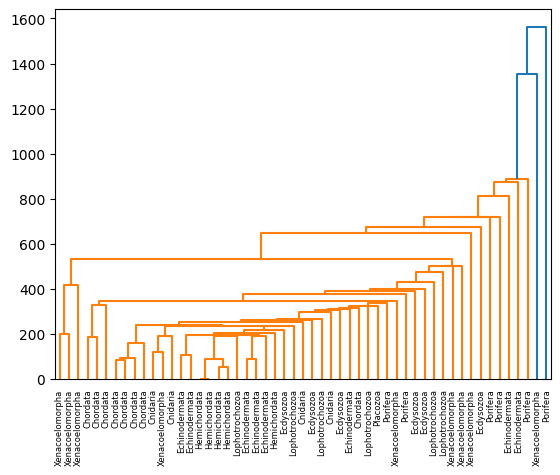

In [189]:
Z, labels = trees[genes[0]]
Z[:,2] = Z[:,2] - min(Z[:,2]) + 1
lab_phyla = []
for i in range(len(labels)):
    lab_phyla.append(species_dict[labels[i]])
plt.figure()
dn = hierarchy.dendrogram(Z, labels=lab_phyla, leaf_rotation=90)
plt.show()


In [ ]:
from scipy.cluster import hierarchy
def getNewick(node, newick, parentdist, leaf_names):
    if node.is_leaf():
        return "%s:%.2f%s" % (leaf_names[node.id], parentdist - node.dist, newick)
    else:
        if len(newick) > 0:
            newick = "):%.2f%s" % (parentdist - node.dist, newick)
        else:
            newick = ");"
        newick = getNewick(node.get_left(), newick, node.dist, leaf_names)
        newick = getNewick(node.get_right(), ",%s" % (newick), node.dist, leaf_names)
        newick = "(%s" % (newick)
        return newick

Newick = {}
for gene in genes:
      Z, labels = trees[gene]
      Z[:,2] = Z[:,2] - min(Z[:,2]) + 1
      tree = hierarchy.to_tree(Z,False)
      newi = getNewick(tree, "", tree.dist, labels)
      Newick[gene] = newi